# SHAP Reliability — K-Fold + GLR

- **Calibration curve** (probability reliability)
- **GLR** (Spearman ρ: SHAP vs gradient baseline |∂L/∂x|)
- **ε-sanity** (tiny perturbation test; hit@1)
- **SHAP summary plots**: beeswarm + feature-importance bar

In [ ]:
import os, time, warnings
from typing import Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, brier_score_loss
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn
import torch.optim as optim

import shap
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

def ts() -> str:
    return time.strftime("%Y-%m-%d %H:%M:%S")

def log(msg: str):
    print(f"[{ts()}] {msg}", flush=True)

def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
def _to_2d_features(a):
    a = np.asarray(a)
    if a.ndim == 3 and a.shape[1] == 1:
        a = a[:, 0, :]
    elif a.ndim == 3 and a.shape[-1] == 1:
        a = a[:, :, 0]
    else:
        a = np.squeeze(a)
    if a.ndim == 1:
        a = a.reshape(1, -1)
    if a.ndim != 2:
        a = a.reshape(a.shape[0], -1)
    return a

def l1_normalize_rows(A: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    A = np.asarray(A, dtype=np.float32)
    A = np.abs(A)
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    return A

def load_pima_local(csv_path: str) -> Tuple[pd.DataFrame, pd.Series]:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found at: {csv_path}")
    log(f"Loading local CSV: {csv_path}")
    df = pd.read_csv(csv_path)
    df.columns = [str(c).strip() for c in df.columns]
    target_candidates = ["Outcome", "class", "Class", "target"]
    y_name = next((c for c in target_candidates if c in df.columns), None)
    if y_name is None:
        raise RuntimeError(
            f"Could not find target column. Looked for {target_candidates}. Found: {list(df.columns)}"
        )
    y = df[y_name].copy()
    X = df.drop(columns=[y_name]).copy()

    lower = {c.lower(): c for c in X.columns}
    for k in ["glucose","bloodpressure","skinthickness","insulin","bmi","plas","pres","skin","insu","mass"]:
        if k in lower and lower[k] in X.columns:
            X.loc[X[lower[k]] == 0, lower[k]] = np.nan
    X = X.fillna(X.median(numeric_only=True))
    X = X.apply(pd.to_numeric, errors="coerce")
    y = y.apply(lambda v: 1 if str(v).strip().lower() in {"1","true","pos","tested_positive","yes","positive"} else 0)
    log(f"[INFO] Columns: {list(X.columns)}")
    log(f"[INFO] Positive count: {int(y.sum())} / {len(y)}")
    return X, y


In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 32, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

class EarlyStopper:
    def __init__(self, patience=10, mode="max"):
        self.best = -np.inf if mode == "max" else np.inf
        self.patience = patience
        self.count = 0
        self.mode = mode
        self.stop = False
    def step(self, value):
        improved = (value > self.best) if self.mode == "max" else (value < self.best)
        if improved:
            self.best = value
            self.count = 0
        else:
            self.count += 1
            if self.count >= self.patience:
                self.stop = True


In [4]:
def shap_importances(model: nn.Module, X_s: np.ndarray, bg_s: np.ndarray, device: str = "cpu"):
    model.eval()
    with torch.no_grad():
        probe = model(torch.tensor(X_s[:2], dtype=torch.float32).to(device))
        assert probe.ndim == 2 and probe.shape[1] == 1, f"Model output must be (N,1), got {probe.shape}"
    log("Computing SHAP attributions (DeepExplainer)...")
    bg_t = torch.tensor(np.array(bg_s), dtype=torch.float32).to(device)
    X_t  = torch.tensor(X_s, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, bg_t)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sv = explainer.shap_values(X_t, check_additivity=False)
    if isinstance(sv, list):
        sv = sv[0]
    sv = _to_2d_features(sv)
    S = l1_normalize_rows(sv)
    log("SHAP complete.")
    return S, sv

def grad_importances(model: nn.Module, X_s: np.ndarray, y: np.ndarray, device: str = "cpu"):
    log("Computing |dL/dx| per sample...")
    model.eval()
    n, d = X_s.shape
    G = np.zeros((n, d), dtype=np.float32)
    loss_fn = nn.BCEWithLogitsLoss()
    for i in range(n):
        xi = torch.tensor(X_s[i:i+1], dtype=torch.float32, requires_grad=True).to(device)
        yi = torch.tensor([[float(y[i])]], dtype=torch.float32).to(device)
        model.zero_grad(set_to_none=True)
        loss = loss_fn(model(xi), yi)
        loss.backward()
        gi = xi.grad.detach().abs().cpu().numpy()[0]
        G[i] = gi
    G = l1_normalize_rows(G)
    log("Gradient baseline complete.")
    return G

def glr_score(S_norm: np.ndarray, G_norm: np.ndarray):
    assert S_norm.shape == G_norm.shape
    rhos = []
    for i in range(S_norm.shape[0]):
        rho, _ = spearmanr(S_norm[i], G_norm[i])
        rhos.append(0.0 if np.isnan(rho) else float(rho))
    glr_mean = float(np.mean(rhos))
    log(f"GLR mean (Spearman ρ): {glr_mean:.3f}")
    return glr_mean, np.array(rhos, dtype=np.float32)

def epsilon_sanity(model: nn.Module, X_s: np.ndarray, y: np.ndarray,
                   shap_S: np.ndarray, topk: int = 1, eps: float = 0.05, device: str = "cpu"):
    log("Running ε-perturbation sanity check...")
    model.eval()
    n, d = X_s.shape
    loss_fn = nn.BCEWithLogitsLoss()
    hits = 0
    for i in range(n):
        xi = torch.tensor(X_s[i:i+1], dtype=torch.float32, requires_grad=True).to(device)
        yi = torch.tensor([[float(y[i])]], dtype=torch.float32).to(device)
        model.zero_grad(set_to_none=True)
        base_loss = loss_fn(model(xi), yi)
        base_loss.backward()
        grad_sign = np.sign(xi.grad.detach().cpu().numpy()[0])
        delta = np.zeros(d, dtype=np.float32)
        for j in range(d):
            xj = xi.detach().clone()
            xj[0, j] += eps * (1.0 if grad_sign[j] >= 0 else -1.0)
            with torch.no_grad():
                dl = loss_fn(model(xj), yi).item() - base_loss.item()
            delta[j] = dl
        top_loss = np.argsort(-delta)[:topk]
        top_shap = np.argsort(-shap_S[i])[:topk]
        if len(set(top_loss).intersection(set(top_shap))) > 0:
            hits += 1
    hit_rate = hits / n
    log(f"ε-sanity hit@{topk}: {hit_rate:.3f}")
    return hit_rate


In [5]:
def train_one_fold(X_tr, y_tr, X_va, y_va, epochs=50, device="cpu", early_patience=10):
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_va_s = scaler.transform(X_va)

    Xtr_t = torch.tensor(X_tr_s, dtype=torch.float32).to(device)
    ytr_t = torch.tensor(y_tr,   dtype=torch.float32).unsqueeze(1).to(device)
    Xva_t = torch.tensor(X_va_s, dtype=torch.float32).to(device)

    model = MLP(in_dim=Xtr_t.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    pos = float(y_tr.sum()); neg = float(len(y_tr) - pos)
    pos_w = torch.tensor([neg / max(pos, 1e-9)], dtype=torch.float32).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_w)

    es = EarlyStopper(patience=early_patience, mode="max")
    best_auc, best_state = -np.inf, None
    log(f"Training for up to {epochs} epochs...")
    for ep in range(1, epochs + 1):
        model.train()
        idx = torch.randperm(Xtr_t.size(0))
        total = 0.0
        bs = 64
        for i in range(0, Xtr_t.size(0), bs):
            b = idx[i:i+bs]
            xb, yb = Xtr_t[b], ytr_t[b]
            opt.zero_grad(set_to_none=True)
            logit = model(xb)
            loss  = loss_fn(logit, yb)
            loss.backward()
            opt.step()
            total += loss.item() * len(b)
        model.eval()
        with torch.no_grad():
            val_logit = model(Xva_t).cpu().numpy().ravel()
            val_prob  = 1 / (1 + np.exp(-val_logit))
        auc = float(roc_auc_score(y_va, val_prob))
        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        if ep % max(1, epochs // 5) == 0 or ep in (1, epochs):
            log(f"  Ep {ep:3d}/{epochs} | train_loss={total/len(X_tr):.4f} | val_auc={auc:.3f}")
        es.step(auc)
        if es.stop:
            log(f"Early stop at epoch {ep} (best AUC={best_auc:.3f})")
            break
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        val_logit = model(Xva_t).cpu().numpy().ravel()
        val_prob  = 1 / (1 + np.exp(-val_logit))
    acc05 = float(accuracy_score(y_va, (val_prob >= 0.5).astype(int)))
    fpr, tpr, thr = roc_curve(y_va, val_prob)
    youden = tpr - fpr
    t_idx = int(np.argmax(youden))
    j_thr = float(thr[t_idx])
    accJ  = float(accuracy_score(y_va, (val_prob >= j_thr).astype(int)))
    brier = float(brier_score_loss(y_va, val_prob))
    p_true, p_pred = calibration_curve(y_va, val_prob, n_bins=10, strategy="quantile")
    metrics = {"auc": best_auc, "acc_0p5": acc05, "thr_youden": j_thr, "acc_youden": accJ, "brier_uncal": brier}
    extras = {"X_tr_s": X_tr_s, "X_va_s": X_va_s, "val_prob": val_prob, "calib_true": p_true, "calib_pred": p_pred}
    return model, metrics, extras


In [6]:
def run_kfold_shap(csv_path: str, k: int = 5, epochs: int = 50, device: str = "cpu", kmeans_k: int = 50, random_state: int = 42):
    set_seed(42)
    Xdf, y_ser = load_pima_local(csv_path)
    X = Xdf.values
    y = y_ser.values.astype(int)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    folds_metrics = []
    folds_cal_true, folds_cal_pred = [], []
    folds_glr_rhos = []
    last = {}
    for f, (tr, va) in enumerate(skf.split(X, y), start=1):
        log("="*60); log(f"Fold {f}/{k}")
        X_tr, X_va = X[tr], X[va]
        y_tr, y_va = y[tr], y[va]
        model, metrics, extras = train_one_fold(X_tr, y_tr, X_va, y_va, epochs=epochs, device=device, early_patience=10)
        folds_metrics.append(metrics)
        folds_cal_true.append(extras["calib_true"])
        folds_cal_pred.append(extras["calib_pred"])

        log(f"Building SHAP background (kmeans K={kmeans_k})...")
        bg_obj = shap.kmeans(extras["X_tr_s"], kmeans_k)
        try:
            bg = np.array(bg_obj.data)
        except AttributeError:
            bg = np.array(bg_obj)

        S_norm, shap_raw = shap_importances(model, extras["X_va_s"], bg, device=device)

        G_norm = grad_importances(model, extras["X_va_s"], y_va, device=device)
        S_norm = _to_2d_features(S_norm); G_norm = _to_2d_features(G_norm)
        glr_mean, rhos = glr_score(S_norm, G_norm)
        hit_at1 = epsilon_sanity(model, extras["X_va_s"], y_va, shap_S=S_norm, topk=1, eps=0.05, device=device)
        last = {
            "X_va_df": pd.DataFrame(extras["X_va_s"], columns=Xdf.columns),
            "y_va": y_va,
            "shap_raw": shap_raw,
            "shap_norm": S_norm,
            "val_prob": extras["val_prob"],
            "metrics": metrics,
            "glr_mean": glr_mean,
            "rhos": rhos,
            "hit_at1": hit_at1
        }
        folds_glr_rhos.append(rhos)
    aucs   = [m["auc"] for m in folds_metrics]
    acc05  = [m["acc_0p5"] for m in folds_metrics]
    accJ   = [m["acc_youden"] for m in folds_metrics]
    briers = [m["brier_uncal"] for m in folds_metrics]
    log("\n======== FINAL SUMMARY ========")
    log(f"AUC        : mean={np.mean(aucs):.3f}  std={np.std(aucs):.3f}")
    log(f"ACC@0.5    : mean={np.mean(acc05):.3f} std={np.std(acc05):.3f}")
    log(f"ACC@J*     : mean={np.mean(accJ):.3f}  std={np.std(accJ):.3f}")
    log(f"Brier (unc): mean={np.mean(briers):.3f} std={np.std(briers):.3f}")
    all_rhos = np.concatenate(folds_glr_rhos) if folds_glr_rhos else np.array([])
    return {"folds_metrics": folds_metrics, "folds_cal_true": folds_cal_true, "folds_cal_pred": folds_cal_pred,
            "all_rhos": all_rhos, "last": last}


In [7]:
def plot_calibration(folds_cal_true, folds_cal_pred, title="Reliability Diagram (Validation)"):
    plt.figure(figsize=(6.5, 6.5))
    for pt, pp in zip(folds_cal_true, folds_cal_pred):
        plt.plot(pp, pt, marker='o', alpha=0.6, linewidth=1)
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
    plt.xlabel("Predicted probability")
    plt.ylabel("True fraction of positives")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_glr_histogram(all_rhos, title="GLR (Spearman ρ) — SHAP vs Gradients"):
    if all_rhos.size == 0:
        log("No GLR values to plot.")
        return
    plt.figure(figsize=(6.5, 4.0))
    plt.hist(all_rhos, bins=20, alpha=0.9)
    plt.xlabel("Spearman ρ (per-sample across features)")
    plt.ylabel("Count")
    plt.title(title + f"\nMean ρ = {np.mean(all_rhos):.3f} ± {np.std(all_rhos):.3f}")
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

def plot_shap_beeswarm(shap_raw, X_val_df, max_display=12):
    plt.figure(figsize=(1,1)); plt.close()
    shap.summary_plot(shap_raw, X_val_df, show=True, max_display=max_display)

def plot_shap_bar(shap_raw, X_val_df, top_k=12):
    vals = np.abs(shap_raw).mean(axis=0)
    order = np.argsort(vals)[::-1][:top_k]
    names = np.array(X_val_df.columns)[order]
    plt.figure(figsize=(7, 4))
    plt.barh(range(len(order)), vals[order][::-1])
    plt.yticks(range(len(order)), names[::-1])
    plt.xlabel("Mean |SHAP value|")
    plt.title("Feature importance (mean |SHAP|)")
    plt.tight_layout()
    plt.show()


[2025-09-04 00:43:32] Loading local CSV: ../dataset/diabetes.csv
[2025-09-04 00:43:32] [INFO] Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
[2025-09-04 00:43:32] [INFO] Positive count: 268 / 768
[2025-09-04 00:43:32] ============================================================
[2025-09-04 00:43:32] Fold 1/5
[2025-09-04 00:43:32] Training for up to 50 epochs...
[2025-09-04 00:43:32]   Ep   1/50 | train_loss=0.8905 | val_auc=0.749
[2025-09-04 00:43:32]   Ep  10/50 | train_loss=0.6718 | val_auc=0.823
[2025-09-04 00:43:32]   Ep  20/50 | train_loss=0.6141 | val_auc=0.839
[2025-09-04 00:43:32]   Ep  30/50 | train_loss=0.5788 | val_auc=0.839
[2025-09-04 00:43:32] Early stop at epoch 34 (best AUC=0.843)
[2025-09-04 00:43:32] Building SHAP background (kmeans K=50)...
[2025-09-04 00:43:33] Computing SHAP attributions (DeepExplainer)...
[2025-09-04 00:43:33] SHAP complete.
[2025-09-04 00:43:33] Computing |dL/dx| per samp

/var/folders/_1/2bt5q7p56r397l7fbpm1jk100000gn/T/ipykernel_99144/3884643480.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_raw, X_val_df, show=True, max_display=max_display)


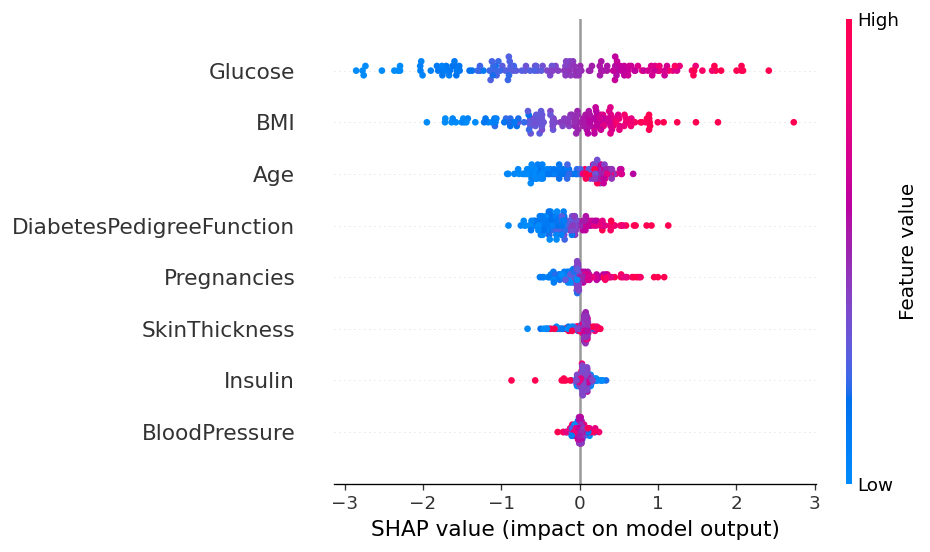

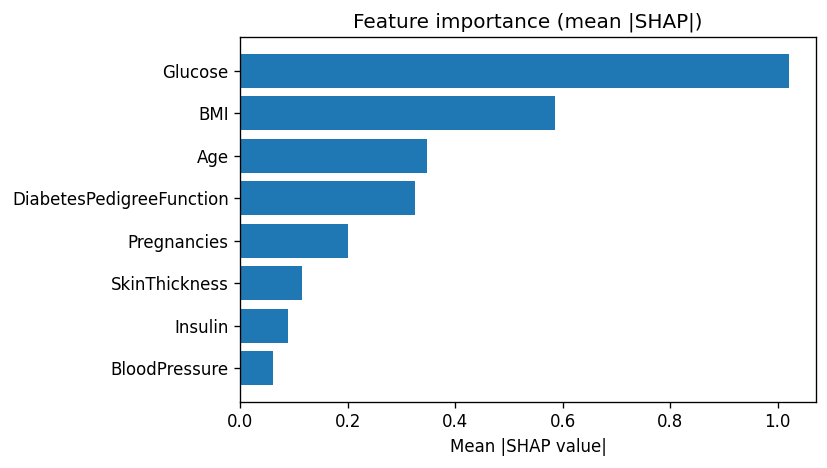

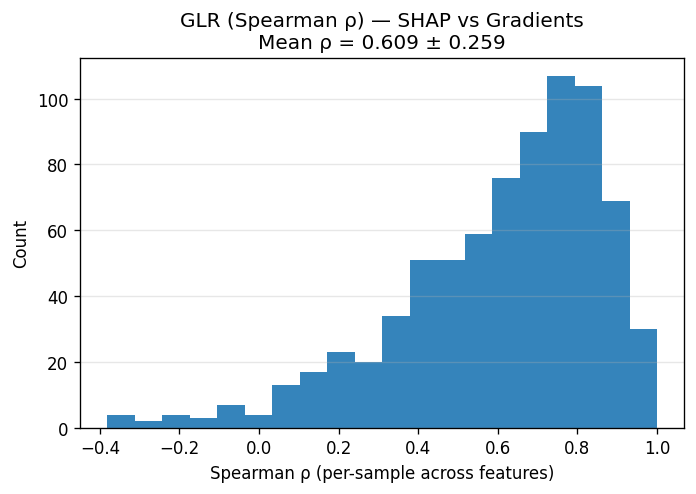

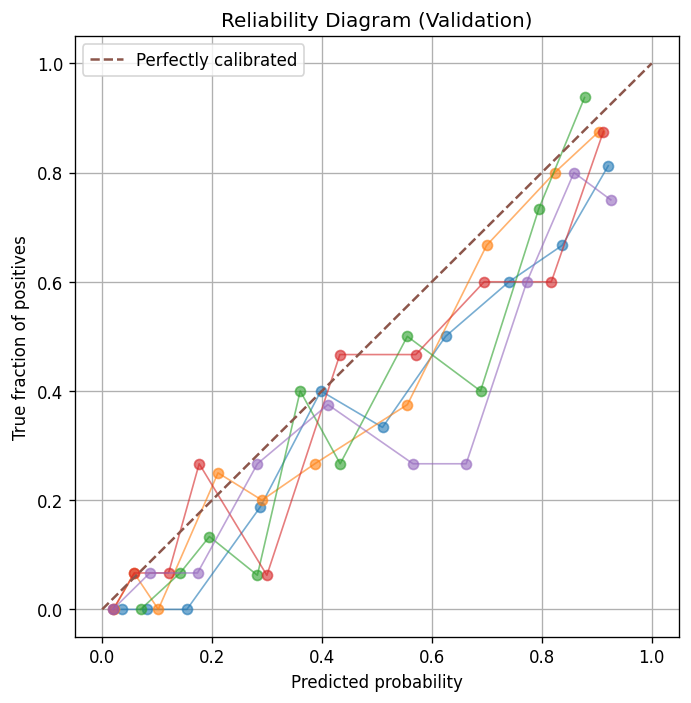

In [8]:
csv_path = "../dataset/diabetes.csv"

out = run_kfold_shap(csv_path=csv_path, k=5, epochs=50, device="cpu", kmeans_k=50, random_state=42)

last = out["last"]
plot_shap_beeswarm(last["shap_raw"], last["X_va_df"]) 
plot_shap_bar(last["shap_raw"], last["X_va_df"])

plot_glr_histogram(out["all_rhos"])

plot_calibration(out["folds_cal_true"], out["folds_cal_pred"]) 